# Intraday Backtest (NSE) — TA‑Lib Candles + RSI + MACD + Support/Resistance

This notebook implements a **pure‑Python** intraday backtester:

- Pulls intraday OHLCV from Yahoo Finance for an **NSE stock** (e.g., `RELIANCE.NS`).
- Detects **TA‑Lib** candlestick patterns and combines them with **RSI**, **MACD**, and simple **Support/Resistance** rules.
- Respects **IST market hours** (09:15–15:30) and **forces exit by 15:14** to avoid auto square‑off.
- Applies **Groww‑style brokerage & regulatory charges** + **slippage** per trade (configurable).
- Produces trade list, P&L, equity curve, and basic performance stats.

**Install requirements**:
```bash
pip install pandas numpy yfinance matplotlib TA-Lib pytz
```
If TA‑Lib fails to install, refer to: https://mrjbq7.github.io/ta-lib/install.html

> ⚠️ Educational use only. Markets are risky; validate fees/charges with your broker and backtest across multiple symbols/periods.

## Parameters

In [8]:

# ---- User parameters ----
import pandas as pd
import numpy as np
import yfinance as yf
import talib
import matplotlib.pyplot as plt
import pytz
from datetime import time

# NSE example: 'RELIANCE.NS', 'TCS.NS', 'INFY.NS', 'HDFCBANK.NS'
TICKER   = "TCS.NS"
INTERVAL = "5m"          # '1m','2m','5m','15m' (yfinance minute data usually limited to ~30 days)
START    = None          # e.g., "2025-07-01" or None
END      = None

# Strategy knobs
RSI_LEN = 14
MACD_FAST, MACD_SLOW, MACD_SIG = 12, 26, 9
ATR_LEN = 14

SR_LOOKBACK = 40           # bars for simple support/resistance (rolling highs/lows)
BREAKOUT_TOL = 0.001       # 0.1% above/below for breakout confirmation
NEAR_SR_ATR_MULT = 0.25    # price considered "near" S/R if within 0.25*ATR

# Risk & money management
START_CAPITAL = 1_000_00.0  # ₹1 lakhs
RISK_PER_TRADE = 0.01        # 1% of capital risk per trade
ATR_SL_MULT = 1.5            # Stop-loss distance = 1.5 * ATR
ATR_TP_MULT = 2.0            # Take-profit distance = 2.0 * ATR
POSITION_CAP_PCT = 0.90      # Max 90% of capital into notional

# Costs & execution
SLIPPAGE_BPS = 5             # 5 bps per side (0.05%) default
ENFORCE_SQUARE_OFF = True    # Force exit by 15:14 IST

# Brokerage/charges model (tweak to match latest Groww schedule)
FEES = {
    "brokerage_scheme": "standard",  # 'standard' or 'upi' (example toggles)
    "brokerage_rate_std": 0.001,     # 0.1% of turnover
    "brokerage_min": 5.0,
    "brokerage_max": 20.0,
    "brokerage_rate_upi": 0.01,      # 1% of turnover (if using a special scheme)
    "stt_intraday_sell": 0.00025,    # 0.025% on SELL turnover
    "stamp_intraday_buy": 0.00003,   # 0.003% on BUY turnover
    "exchange_txn": 0.0000297,       # per side
    "sebi": 0.000001,                # per side
    "ipft": 0.000001,                # per side
    "gst": 0.18,                     # 18% on (brokerage + exchange + sebi + ipft)
    "auto_square_off_fee": 59.0      # RMS penalty if closed by broker
}

# TA-Lib patterns (you can customize these)
BULL_PATTERNS = ["CDLENGULFING", "CDLHAMMER", "CDLMORNINGSTAR", "CDLPIERCING"]
BEAR_PATTERNS = ["CDLEVENINGSTAR", "CDLSHOOTINGSTAR", "CDLENGULFING", "CDLDARKCLOUDCOVER"]


## Helpers: market hours, fees, slippage

In [9]:

IST = pytz.timezone("Asia/Kolkata")
SESSION_START = time(9, 15)
SESSION_END   = time(15, 30)     # Market close
FORCE_EXIT_TIME = time(15, 14)   # Exit before 15:15 to avoid potential square-off fees

def in_session(ts):
    # True if timestamp (tz-aware IST) is within regular session.
    t = ts.time()
    return (t >= SESSION_START) and (t <= SESSION_END)

def calc_brokerage(turnover, fees):
    if fees["brokerage_scheme"] == "upi":
        return fees["brokerage_rate_upi"] * turnover
    # standard capped slab: min(max(min_fee, rate*turnover), max_fee)
    x = fees["brokerage_rate_std"] * turnover
    x = max(fees["brokerage_min"], x)
    return min(fees["brokerage_max"], x)

def calc_side_charges(side, turnover, fees):
    side = side.upper()
    brk = calc_brokerage(turnover, fees)
    stt = fees["stt_intraday_sell"] * turnover if side == "SELL" else 0.0
    stamp = fees["stamp_intraday_buy"] * turnover if side == "BUY" else 0.0
    exch = fees["exchange_txn"] * turnover
    sebi = fees["sebi"] * turnover
    ipft = fees["ipft"] * turnover
    gst = fees["gst"] * (brk + exch + sebi + ipft)
    total = brk + stt + stamp + exch + sebi + ipft + gst
    return {"brokerage": brk, "stt": stt, "stamp": stamp, "exchange": exch, "sebi": sebi, "ipft": ipft, "gst": gst, "total": total}

def apply_slippage_px(px, side, bps):
    frac = bps / 10000.0
    if side.upper() == "BUY":
        return px * (1 + frac)
    else:
        return px * (1 - frac)


## Download data (yfinance) & keep IST session only

In [10]:

# Download intraday data
df = yf.download(TICKER, start=START, end=END, interval=INTERVAL, auto_adjust=False, progress=False, multi_level_index=False)
if df.empty:
    raise RuntimeError("No data downloaded. Try a different ticker/date range/interval.")

# Convert to IST and filter session
if df.index.tz is None:
    df = df.tz_localize('UTC')
df = df.tz_convert(IST)
df = df.between_time(SESSION_START, SESSION_END)

# Standardize column names
df = df.rename(columns=str.title)[['Open','High','Low','Close','Volume']].copy()
df.dropna(inplace=True)
df.head()


,Open,High,Low,Close,Volume
Datetime,,,,,
2025-07-28 09:15:00+05:30,3111.100098,3111.100098,3082.000000,3090.899902,0
2025-07-28 09:20:00+05:30,3090.600098,3096.399902,3085.500000,3095.800049,78631
2025-07-28 09:25:00+05:30,3095.800049,3096.600098,3089.199951,3094.600098,53116
2025-07-28 09:30:00+05:30,3094.300049,3099.899902,3093.899902,3097.000000,132260
2025-07-28 09:35:00+05:30,3097.100098,3099.000000,3093.399902,3097.000000,25351


## Indicators: RSI, MACD, ATR, Candles, Support/Resistance

In [11]:

# Indicators
rsi = talib.RSI(df['Close'].values, timeperiod=RSI_LEN)
macd, macdsig, macdhist = talib.MACD(df['Close'].values, fastperiod=MACD_FAST, slowperiod=MACD_SLOW, signalperiod=MACD_SIG)
atr = talib.ATR(df['High'].values, df['Low'].values, df['Close'].values, timeperiod=ATR_LEN)

def pattern_signal(names):
    total = np.zeros(len(df), dtype=float)
    for name in names:
        func = getattr(talib, name, None)
        if func is None:
            print(f"[WARN] No TA-Lib function: {name}")
            continue
        vals = func(df['Open'].values, df['High'].values, df['Low'].values, df['Close'].values)
        total += vals.astype(float)
    return total

bull_sig = pattern_signal(BULL_PATTERNS)   # >0 bullish tilt
bear_sig = pattern_signal(BEAR_PATTERNS)   # <0 bearish tilt

# Simple support/resistance via rolling highs/lows
roll_high = df['High'].rolling(SR_LOOKBACK, min_periods=1).max()
roll_low  = df['Low'].rolling(SR_LOOKBACK, min_periods=1).min()

# Append
df['RSI'] = rsi
df['MACD'] = macd
df['MACD_SIG'] = macdsig
df['MACD_HIST'] = macdhist
df['ATR'] = atr
df['BULL'] = bull_sig
df['BEAR'] = bear_sig
df['RES'] = roll_high.shift(1)  # previous bar's resistance
df['SUP'] = roll_low.shift(1)   # previous bar's support
df.dropna(inplace=True)
df.tail()


,Open,High,Low,Close,Volume,RSI,MACD,MACD_SIG,MACD_HIST,ATR,BULL,BEAR,RES,SUP
Datetime,,,,,,,,,,,,,,
2025-08-26 15:05:00+05:30,3156.300049,3158.800049,3154.300049,3155.300049,319002,53.119242,1.418549,1.839402,-0.420853,4.110457,0.0,0.0,3162.0,3141.300049
2025-08-26 15:10:00+05:30,3155.500000,3156.600098,3154.899902,3155.100098,342798,52.653590,1.287291,1.728979,-0.441688,3.938295,0.0,0.0,3162.0,3141.300049
2025-08-26 15:15:00+05:30,3155.100098,3159.000000,3154.899902,3155.199951,379293,52.875756,1.177750,1.618734,-0.440984,3.949853,0.0,0.0,3162.0,3141.300049
2025-08-26 15:20:00+05:30,3155.300049,3161.100098,3155.100098,3157.800049,780858,58.355494,1.285920,1.552171,-0.266251,4.096292,0.0,0.0,3162.0,3141.300049
2025-08-26 15:25:00+05:30,3157.899902,3159.800049,3156.600098,3157.199951,218504,56.716264,1.308143,1.503365,-0.195222,4.032267,0.0,0.0,3162.0,3141.699951


## Strategy rules and event‑driven backtest (no frameworks)

In [12]:

close = df['Close']; high = df['High']; low = df['Low']; openp = df['Open']

# Conditions
macd_up = (df['MACD'] > df['MACD_SIG']) & (df['MACD_HIST'] > 0) & (df['MACD_HIST'].diff() > 0)
macd_dn = (df['MACD'] < df['MACD_SIG']) & (df['MACD_HIST'] < 0) & (df['MACD_HIST'].diff() < 0)
rsi_up = df['RSI'] > 50
rsi_dn = df['RSI'] < 50

near_sup = (close - df['SUP']).abs() <= (NEAR_SR_ATR_MULT * df['ATR'])
near_res = (df['RES'] - close).abs() <= (NEAR_SR_ATR_MULT * df['ATR'])

breakout_up = close > (df['RES'] * (1 + BREAKOUT_TOL))
breakout_dn = close < (df['SUP'] * (1 - BREAKOUT_TOL))

bull_pat = df['BULL'] > 0
bear_pat = df['BEAR'] < 0

long_signal = (bull_pat & rsi_up & macd_up & (breakout_up | near_sup))
short_signal = (bear_pat & rsi_dn & macd_dn & (breakout_dn | near_res))

# Execute on next bar open to avoid look-ahead
long_sig_exec = long_signal.shift(1).fillna(False)
short_sig_exec = short_signal.shift(1).fillna(False)

# Backtest engine
capital = START_CAPITAL
position = 0  # +qty long, -qty short
entry_px = None; entry_time = None; entry_atr = None
trades = []

equity_curve = []
times = []

def size_for_atr(capital, atr_val, price):
    # Risk per share ≈ ATR_SL_MULT * ATR
    risk_amt = capital * RISK_PER_TRADE
    per_share_risk = ATR_SL_MULT * atr_val
    if per_share_risk <= 0:
        return 0
    qty = int(risk_amt // per_share_risk)
    max_qty = int((POSITION_CAP_PCT * capital) // price)
    return max(0, min(qty, max_qty))

for ts, row in df.iterrows():
    # Forced exit at 15:14 IST
    if ENFORCE_SQUARE_OFF and position != 0 and ts.time() >= FORCE_EXIT_TIME:
        side = "SELL" if position > 0 else "BUY"
        px = apply_slippage_px(row['Open'], side, SLIPPAGE_BPS)
        qty = abs(position)
        turnover = qty * px
        charges1 = calc_side_charges(side, turnover, FEES)
        pnl = (px - entry_px) * position
        trades.append({
            "entry_time": entry_time, "entry_px": entry_px, "side": "LONG" if position>0 else "SHORT",
            "exit_time": ts, "exit_px": px, "reason": "Forced_1514",
            "qty": qty, "gross_pnl": pnl, "exit_charges": charges1
        })
        capital += pnl - charges1["total"]
        position = 0; entry_px = entry_time = entry_atr = None

    # Natural exits: ATR SL / TP while position open
    if position != 0:
        stop = entry_px - ATR_SL_MULT * entry_atr if position > 0 else entry_px + ATR_SL_MULT * entry_atr
        tp   = entry_px + ATR_TP_MULT * entry_atr if position > 0 else entry_px - ATR_TP_MULT * entry_atr
        exit_px = None; exit_reason = None
        side_exit = "SELL" if position > 0 else "BUY"
        if position > 0:
            if row['Low'] <= stop:
                exit_px = apply_slippage_px(stop, side_exit, SLIPPAGE_BPS); exit_reason = "Stop"
            elif row['High'] >= tp:
                exit_px = apply_slippage_px(tp, side_exit, SLIPPAGE_BPS); exit_reason = "TakeProfit"
        else:
            if row['High'] >= stop:
                exit_px = apply_slippage_px(stop, side_exit, SLIPPAGE_BPS); exit_reason = "Stop"
            elif row['Low'] <= tp:
                exit_px = apply_slippage_px(tp, side_exit, SLIPPAGE_BPS); exit_reason = "TakeProfit"
        if exit_px is not None:
            qty = abs(position)
            turnover = qty * exit_px
            charges1 = calc_side_charges(side_exit, turnover, FEES)
            pnl = (exit_px - entry_px) * position
            trades.append({
                "entry_time": entry_time, "entry_px": entry_px, "side": "LONG" if position>0 else "SHORT",
                "exit_time": ts, "exit_px": exit_px, "reason": exit_reason,
                "qty": qty, "gross_pnl": pnl, "exit_charges": charges1
            })
            capital += pnl - charges1["total"]
            position = 0; entry_px = entry_time = entry_atr = None

    # Entries (only if flat and during session)
    if position == 0 and in_session(ts):
        if long_sig_exec.loc[ts]:
            px = apply_slippage_px(row['Open'], "BUY", SLIPPAGE_BPS)
            qty = size_for_atr(capital, row['ATR'], px)
            if qty > 0:
                turnover = qty * px
                charges0 = calc_side_charges("BUY", turnover, FEES)
                if (qty * px + charges0["total"]) <= capital * POSITION_CAP_PCT:
                    position = qty; entry_px = px; entry_time = ts; entry_atr = row['ATR']
                    capital -= charges0["total"]
                    trades.append({
                        "entry_time": entry_time, "entry_px": entry_px, "side": "LONG",
                        "qty": qty, "entry_charges": charges0
                    })
        elif short_sig_exec.loc[ts]:
            px = apply_slippage_px(row['Open'], "SELL", SLIPPAGE_BPS)
            qty = size_for_atr(capital, row['ATR'], px)
            if qty > 0:
                turnover = qty * px
                charges0 = calc_side_charges("SELL", turnover, FEES)
                if (qty * px + charges0["total"]) <= capital * POSITION_CAP_PCT:
                    position = -qty; entry_px = px; entry_time = ts; entry_atr = row['ATR']
                    capital -= charges0["total"]
                    trades.append({
                        "entry_time": entry_time, "entry_px": entry_px, "side": "SHORT",
                        "qty": qty, "entry_charges": charges0
                    })

    # End-of-session safety: if still open at 15:30, exit at Close and add RMS fee
    if ts.time() == SESSION_END and position != 0:
        side = "SELL" if position > 0 else "BUY"
        px = apply_slippage_px(row['Close'], side, SLIPPAGE_BPS)
        qty = abs(position)
        turnover = qty * px
        charges1 = calc_side_charges(side, turnover, FEES)
        charges1["total"] += FEES["auto_square_off_fee"]
        pnl = (px - entry_px) * position
        trades.append({
            "entry_time": entry_time, "entry_px": entry_px, "side": "LONG" if position>0 else "SHORT",
            "exit_time": ts, "exit_px": px, "reason": "RMS_AutoSquareOff",
            "qty": qty, "gross_pnl": pnl, "exit_charges": charges1
        })
        capital += pnl - charges1["total"]
        position = 0; entry_px = entry_time = entry_atr = None

    equity_curve.append(capital); times.append(ts)

eq = pd.Series(equity_curve, index=pd.DatetimeIndex(times))

# Build trade table combining entry & exit records
rows = []; open_leg = None
for rec in trades:
    if "exit_time" not in rec:
        open_leg = rec
    else:
        base = {}
        if open_leg and open_leg.get("entry_time") == rec.get("entry_time") and open_leg.get("side") == rec.get("side"):
            base.update(open_leg)
        base.update(rec)
        rows.append(base); open_leg = None

trades_df = pd.DataFrame(rows)

if not trades_df.empty:
    def leg_total(d):
        return float(d["total"]) if isinstance(d, dict) and ("total" in d) else 0.0
    trades_df["entry_cost"] = trades_df["entry_charges"].apply(leg_total)
    trades_df["exit_cost"]  = trades_df["exit_charges"].apply(leg_total)
    trades_df["fees"] = trades_df["entry_cost"] + trades_df["exit_cost"]
    trades_df["net_pnl"] = trades_df["gross_pnl"] - trades_df["fees"]

# Summary
def max_drawdown(series):
    roll_max = series.cummax()
    dd = (series - roll_max)
    dd_pct = dd / roll_max.replace(0, np.nan)
    return float(dd.min()), float((dd_pct.min() if dd_pct.notna().any() else 0.0))

if len(eq) > 1:
    dd_abs, dd_pct = max_drawdown(eq.astype(float))
else:
    dd_abs, dd_pct = (0.0, 0.0)

summary = {
    "trades": int(len(trades_df)) if not trades_df.empty else 0,
    "final_capital": float(eq.iloc[-1]) if len(eq)>0 else float(START_CAPITAL),
    "net_profit": float(eq.iloc[-1] - START_CAPITAL) if len(eq)>0 else 0.0,
    "win_rate_%": float((trades_df["net_pnl"]>0).mean()*100) if not trades_df.empty else 0.0,
    "avg_net_per_trade": float(trades_df["net_pnl"].mean()) if not trades_df.empty else 0.0,
    "total_fees": float(trades_df["fees"].sum()) if not trades_df.empty else 0.0,
    "max_dd_abs": dd_abs,
    "max_dd_pct": dd_pct*100.0,
}
print("Summary:", summary)

if not trades_df.empty:
    display(trades_df.head(10))


Summary: {'trades': 2, 'final_capital': 100423.05090498869, 'net_profit': 423.0509049886896, 'win_rate_%': 100.0, 'avg_net_per_trade': 211.52545249434593, 'total_fees': 157.95964558470584, 'max_dd_abs': -29.623910038091708, 'max_dd_pct': -0.02961921594827436}


/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/1516285651.py:22: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  long_sig_exec = long_signal.shift(1).fillna(False)
/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/1516285651.py:23: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  short_sig_exec = short_signal.shift(1).fillna(False)


,entry_time,entry_px,side,qty,entry_charges,exit_time,exit_px,reason,gross_pnl,exit_charges,entry_cost,exit_cost,fees,net_pnl
0,2025-08-12 09:35:00+05:30,3079.238801,LONG,29,"{'brokerage': 20.0, 'stt': 0.0, 'stamp': 2.678...",2025-08-12 09:50:00+05:30,3090.324605,TakeProfit,321.488322,"{'brokerage': 20.0, 'stt': 22.40485338892676, ...",29.619216,49.357157,78.976373,242.511949
1,2025-08-20 11:55:00+05:30,3081.640148,LONG,29,"{'brokerage': 20.0, 'stt': 0.0, 'stamp': 2.681...",2025-08-20 14:35:00+05:30,3090.589190,TakeProfit,259.522228,"{'brokerage': 20.0, 'stt': 22.4067716278975, '...",29.623910,49.359362,78.983272,180.538956


## Plots: Equity Curve and Sample Day

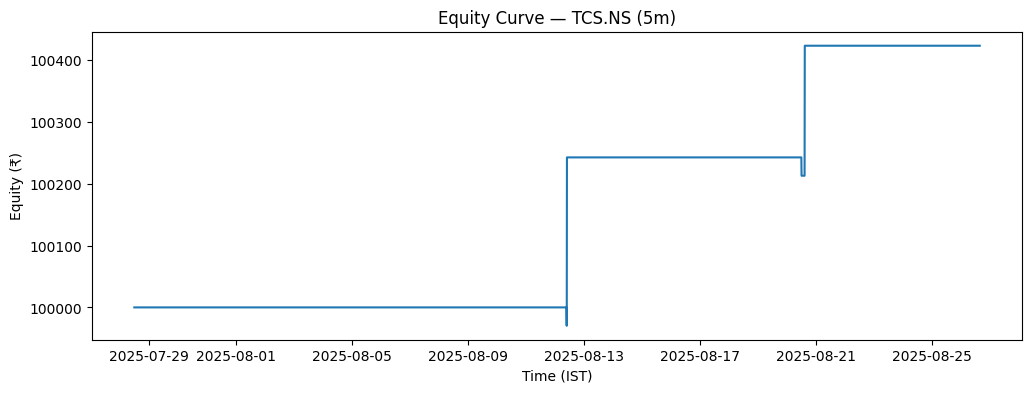

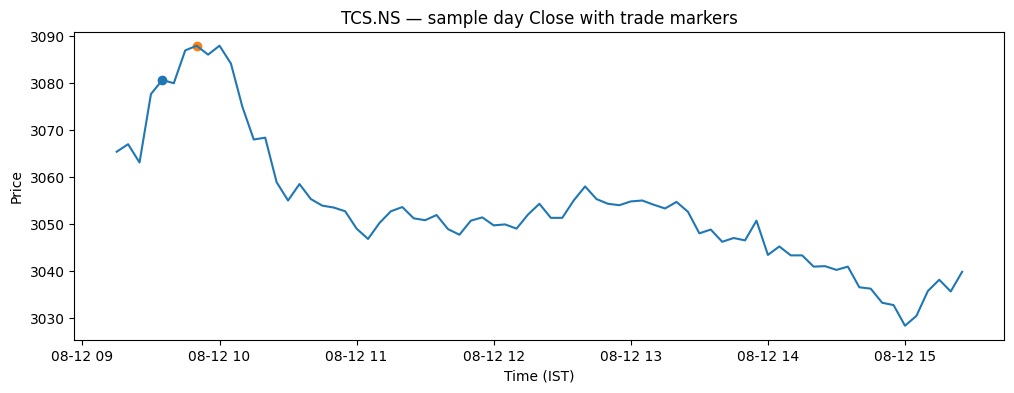

In [13]:

# Equity curve
if len(eq) > 1:
    plt.figure(figsize=(12,4))
    plt.plot(eq.index, eq.values)
    plt.title(f"Equity Curve — {TICKER} ({INTERVAL})")
    plt.xlabel("Time (IST)"); plt.ylabel("Equity (₹)")
    plt.show()

# Plot a sample day's close with entry/exit markers (if any)
if 'trades_df' in locals() and not trades_df.empty:
    day = trades_df['entry_time'].dt.date.iloc[0]
    day_slice = df[df.index.date == day]
    plt.figure(figsize=(12,4))
    plt.plot(day_slice.index, day_slice['Close'])
    for _, tr in trades_df[trades_df['entry_time'].dt.date == day].iterrows():
        if tr['entry_time'] in day_slice.index:
            plt.scatter(tr['entry_time'], day_slice.loc[tr['entry_time'], 'Close'])
        else:
            plt.scatter(tr['entry_time'], tr['entry_px'])
        if pd.notnull(tr.get('exit_time')):
            if tr['exit_time'] in day_slice.index:
                plt.scatter(tr['exit_time'], day_slice.loc[tr['exit_time'], 'Close'])
            else:
                plt.scatter(tr['exit_time'], tr['exit_px'])
    plt.title(f"{TICKER} — sample day Close with trade markers")
    plt.xlabel("Time (IST)"); plt.ylabel("Price")
    plt.show()


## Export results

In [14]:

# Save trades and equity to CSV
trades_path = f"trades_{TICKER.replace('.','_')}_{INTERVAL}.csv"
equity_path = f"equity_{TICKER.replace('.','_')}_{INTERVAL}.csv"
if 'trades_df' in locals() and not trades_df.empty:
    trades_df.to_csv(trades_path, index=False)
    print("Saved trades:", trades_path)
eq.to_csv(equity_path, header=['equity'])
print("Saved equity:", equity_path)


Saved trades: trades_TCS_NS_5m.csv
Saved equity: equity_TCS_NS_5m.csv


# Multi-ticker backtest

In [31]:
import numpy as np
import pandas as pd
import yfinance as yf
import talib
import pytz
from datetime import time

# ========= Parameters (edit here) =========
BASE_TICKERS = ['ADANIENT', 'ADANIPORTS', 'APOLLOHOSP', 'ASIANPAINT', 'AXISBANK', 'BAJAJ-AUTO', 'BAJFINANCE', 'BAJAJFINSV', 'BEL', 'BHARTIARTL', 'CIPLA', 'COALINDIA', 'DRREDDY', 'EICHERMOT', 'ETERNAL', 'GRASIM', 'HCLTECH', 'HDFCBANK', 'HDFCLIFE', 'HEROMOTOCO', 'HINDALCO', 'HINDUNILVR', 'ICICIBANK', 'ITC', 'INDUSINDBK', 'INFY', 'JSWSTEEL', 'JIOFIN', 'KOTAKBANK', 'LT', 'M&M', 'MARUTI', 'NTPC', 'NESTLEIND', 'ONGC', 'POWERGRID', 'RELIANCE', 'SBILIFE', 'SHRIRAMFIN', 'SBIN', 'SUNPHARMA', 'TCS', 'TATACONSUM', 'TATAMOTORS', 'TATASTEEL', 'TECHM', 'TITAN', 'TRENT', 'ULTRACEMCO', 'WIPRO']
TICKERS = [ticker + ".NS" for ticker in BASE_TICKERS]
INTERVAL = "5m"
START    = "2025-08-18"              # e.g. "2025-07-01" or None
END      = "2025-08-22"

# Session (IST)
IST = pytz.timezone("Asia/Kolkata")
SESSION_START   = time(9, 15)
SESSION_END     = time(15, 30)
CUTOFF_TIME     = time(15, 14)   # exit only if still open at/after this time

# Strategy knobs
RSI_LEN = 14
MACD_FAST, MACD_SLOW, MACD_SIG = 12, 26, 9
ATR_LEN = 14
SR_LOOKBACK = 40
BREAKOUT_TOL = 0.001
NEAR_SR_ATR_MULT = 0.25

# Capital, margin & risk
START_CAPITAL     = 100_000.0     # per-ticker capital
LEVERAGE          = 5.0           # 5x intraday margin
RISK_PER_TRADE    = 0.01          # risk % of own capital
ATR_SL_MULT       = 1.5           # SL distance (Stop Loss)
ATR_TP_MULT       = 2.0           # TP distance (Take Profit)
POSITION_CAP_PCT  = 0.90          # of buying power

# Execution
SLIPPAGE_BPS = 5                  # per side

# Groww intraday charges (from your spec)
FEES = {
    "stt_intraday_sell": 0.00025,   # sell only
    "stamp_intraday_buy": 0.00003,  # buy only
    "exchange_txn_nse": 0.0000297,  # both sides
    "sebi": 0.000001,               # both sides
    "ipft_nse": 0.000001,           # both sides
    "gst": 0.18,                    # on (brokerage + exchange + sebi + ipft)
    "rms_auto_square_off_fee": 59.0 # ₹50 + GST
}

BULL_PATTERNS = ["CDLMORNINGSTAR", "CDLMORNINGDOJISTAR", "CDL3WHITESOLDIERS", "CDLABANDONEDBABY"]
BEAR_PATTERNS = ["CDLEVENINGSTAR", "CDLEVENINGDOJISTAR", "CDL3BLACKCROWS", "CDLABANDONEDBABY", "CDLDARKCLOUDCOVER"]



# ========= Helpers =========
def groww_brokerage(turnover: float) -> float:
    base = min(20.0, 0.001 * turnover)
    if base < 5.0:
        return min(5.0, 0.025 * turnover)
    return base

def charges_for_side(side: str, turnover: float) -> float:
    side = side.upper()
    brk  = groww_brokerage(turnover)
    stt  = FEES["stt_intraday_sell"] * turnover if side == "SELL" else 0.0
    stamp= FEES["stamp_intraday_buy"] * turnover if side == "BUY"  else 0.0
    exch = FEES["exchange_txn_nse"] * turnover
    sebi = FEES["sebi"] * turnover
    ipft = FEES["ipft_nse"] * turnover
    gst  = FEES["gst"] * (brk + exch + sebi + ipft)
    return brk + stt + stamp + exch + sebi + ipft + gst

def px_with_slippage(px: float, side: str) -> float:
    frac = SLIPPAGE_BPS / 10000.0
    return px * (1 + frac) if side.upper() == "BUY" else px * (1 - frac)

def talib_pattern_sum(df: pd.DataFrame, names: list) -> np.ndarray:
    o,h,l,c = df["Open"].values, df["High"].values, df["Low"].values, df["Close"].values
    total = np.zeros(len(df), dtype=float)
    for name in names:
        f = getattr(talib, name, None)
        if f is not None:
            total += f(o,h,l,c).astype(float)
    return total

def qty_for_atr(capital: float, atr_val: float, price: float) -> int:
    risk_amt       = capital * RISK_PER_TRADE
    per_share_risk = ATR_SL_MULT * atr_val
    if per_share_risk <= 0: return 0
    q_risk = int(risk_amt // per_share_risk)
    buying_power = capital * LEVERAGE
    q_cap  = int((POSITION_CAP_PCT * buying_power) // price)
    return max(0, min(q_risk, q_cap))

def max_drawdown(series: pd.Series) -> tuple[float,float]:
    if len(series) < 2: return 0.0, 0.0
    peak = series.cummax()
    dd   = series - peak
    dd_pct = (dd / peak.replace(0, np.nan)).min()
    return float(dd.min()), float(dd_pct*100 if pd.notna(dd_pct) else 0.0)

def sharpe_ratio(returns: pd.Series, rf: float = 0.0) -> float:
    if returns.std() == 0: return 0.0
    return (returns.mean() - rf) / returns.std() * np.sqrt(252)

def sortino_ratio(returns: pd.Series, rf: float = 0.0) -> float:
    downside = returns[returns < 0]
    if downside.std() == 0: return 0.0
    return (returns.mean() - rf) / downside.std() * np.sqrt(252)

def profit_factor(net_pnls: pd.Series) -> float:
    if net_pnls.empty: return 0.0
    gains  = net_pnls[net_pnls > 0].sum()
    losses = -net_pnls[net_pnls < 0].sum()
    return float(gains / losses) if losses != 0 else float("inf")

# ========= Backtest for one ticker =========
def run_backtest(ticker: str):
    df = yf.download(ticker, start=START, end=END, interval=INTERVAL, auto_adjust=False, progress=False, multi_level_index=False)
    if df.empty:
        print(f"[WARN] No data for {ticker}")
        return

    if df.index.tz is None:
        df = df.tz_localize("UTC")
    df = df.tz_convert(IST).between_time(SESSION_START, SESSION_END)
    df = df.rename(columns=str.title)[["Open","High","Low","Close","Volume"]].dropna()

    # Indicators
    df["RSI"] = talib.RSI(df["Close"], timeperiod=RSI_LEN)
    macd, sig, hist = talib.MACD(df["Close"], MACD_FAST, MACD_SLOW, MACD_SIG)
    df["MACD"], df["MACD_SIG"], df["MACD_HIST"] = macd, sig, hist
    df["ATR"]  = talib.ATR(df["High"], df["Low"], df["Close"], timeperiod=ATR_LEN)
    df["BULL"] = talib_pattern_sum(df, BULL_PATTERNS)
    df["BEAR"] = talib_pattern_sum(df, BEAR_PATTERNS)
    df["RES"]  = df["High"].rolling(SR_LOOKBACK).max().shift(1)
    df["SUP"]  = df["Low"].rolling(SR_LOOKBACK).min().shift(1)
    df.dropna(inplace=True)

    # Signals
    close   = df["Close"]
    macd_up = (df["MACD"] > df["MACD_SIG"]) & (df["MACD_HIST"] > 0) & (df["MACD_HIST"].diff() > 0)
    macd_dn = (df["MACD"] < df["MACD_SIG"]) & (df["MACD_HIST"] < 0) & (df["MACD_HIST"].diff() < 0)
    rsi_up, rsi_dn = df["RSI"] > 50, df["RSI"] < 50
    near_sup = (close - df["SUP"]).abs() <= (NEAR_SR_ATR_MULT * df["ATR"])
    near_res = (df["RES"] - close).abs() <= (NEAR_SR_ATR_MULT * df["ATR"])
    breakout_up = close > (df["RES"] * (1 + BREAKOUT_TOL))
    breakout_dn = close < (df["SUP"] * (1 - BREAKOUT_TOL))
    bull_pat, bear_pat = df["BULL"] > 0, df["BEAR"] < 0

    long_signal  = (bull_pat & rsi_up & macd_up & (breakout_up | near_sup))
    short_signal = (bear_pat & rsi_dn & macd_dn & (breakout_dn | near_res))

    # Execute at next bar open
    long_exec  = long_signal.shift(1).fillna(False)
    short_exec = short_signal.shift(1).fillna(False)

    capital = START_CAPITAL
    position = 0       # +qty long, -qty short
    entry_px = None
    entry_atr = None
    entry_time = None
    entry_side = None  # "LONG" or "SHORT"
    entry_fee  = 0.0
    trades = []        # list of dicts
    equity = []

    for ts, row in df.iterrows():
        # --- Natural exits ONLY (SL/TP) during the day ---
        if position != 0:
            stop = entry_px - ATR_SL_MULT * entry_atr if position > 0 else entry_px + ATR_SL_MULT * entry_atr
            tp   = entry_px + ATR_TP_MULT * entry_atr if position > 0 else entry_px - ATR_TP_MULT * entry_atr
            exit_px = None; reason = None; exit_side = "SELL" if position > 0 else "BUY"
            # Check SL/TP hits within bar range
            if position > 0:  # LONG
                if row["Low"] <= stop:
                    exit_px, reason = px_with_slippage(stop, exit_side), "Stop"
                elif row["High"] >= tp:
                    exit_px, reason = px_with_slippage(tp,  exit_side), "TakeProfit"
            else:             # SHORT
                if row["High"] >= stop:
                    exit_px, reason = px_with_slippage(stop, exit_side), "Stop"
                elif row["Low"]  <= tp:
                    exit_px, reason = px_with_slippage(tp,  exit_side), "TakeProfit"

            if exit_px is not None:
                qty = abs(position)
                gross_pnl = (exit_px - entry_px) * position
                exit_fee  = charges_for_side(exit_side, qty * exit_px)
                net_pnl   = gross_pnl - exit_fee - entry_fee
                trades.append({
                    "EntryTime": entry_time, "Side": entry_side, "EntryPx": entry_px,
                    "ExitTime": ts, "ExitPx": exit_px, "Reason": reason,
                    "Qty": qty, "GrossPnL": gross_pnl, "Fees": entry_fee + exit_fee, "NetPnL": net_pnl
                })
                capital += net_pnl
                position = 0; entry_px = entry_atr = entry_time = entry_side = None; entry_fee = 0.0

        # --- Entries (flat, before cutoff) ---
        if position == 0 and ts.time() < CUTOFF_TIME:
            if long_exec.loc[ts]:
                px = px_with_slippage(row["Open"], "BUY")
                qty = qty_for_atr(capital, row["ATR"], px)
                if qty > 0:
                    entry_fee = charges_for_side("BUY", qty * px)  # pay now
                    capital -= entry_fee
                    position   = qty
                    entry_px   = px
                    entry_atr  = row["ATR"]
                    entry_time = ts
                    entry_side = "LONG"

            elif short_exec.loc[ts]:
                px = px_with_slippage(row["Open"], "SELL")
                qty = qty_for_atr(capital, row["ATR"], px)
                if qty > 0:
                    entry_fee = charges_for_side("SELL", qty * px)  # pay now
                    capital -= entry_fee
                    position   = -qty
                    entry_px   = px
                    entry_atr  = row["ATR"]
                    entry_time = ts
                    entry_side = "SHORT"

        # --- Cutoff exit: if still open at/after 15:14, exit immediately at bar open ---
        if position != 0 and ts.time() >= CUTOFF_TIME:
            exit_side = "SELL" if position > 0 else "BUY"
            px = px_with_slippage(row["Open"], exit_side)
            qty = abs(position)
            gross_pnl = (px - entry_px) * position
            exit_fee  = charges_for_side(exit_side, qty * px)
            net_pnl   = gross_pnl - exit_fee - entry_fee
            trades.append({
                "EntryTime": entry_time, "Side": entry_side, "EntryPx": entry_px,
                "ExitTime": ts, "ExitPx": px, "Reason": "Cutoff_Exit",
                "Qty": qty, "GrossPnL": gross_pnl, "Fees": entry_fee + exit_fee, "NetPnL": net_pnl
            })
            capital += net_pnl
            position = 0; entry_px = entry_atr = entry_time = entry_side = None; entry_fee = 0.0

        # --- Safety: auto square-off at 15:30 if somehow still open (add RMS fee) ---
        if ts.time() == SESSION_END and position != 0:
            exit_side = "SELL" if position > 0 else "BUY"
            px = px_with_slippage(row["Close"], exit_side)
            qty = abs(position)
            gross_pnl = (px - entry_px) * position
            exit_fee  = charges_for_side(exit_side, qty * px) + FEES["rms_auto_square_off_fee"]
            net_pnl   = gross_pnl - exit_fee - entry_fee
            trades.append({
                "EntryTime": entry_time, "Side": entry_side, "EntryPx": entry_px,
                "ExitTime": ts, "ExitPx": px, "Reason": "RMS_AutoSquareOff",
                "Qty": qty, "GrossPnL": gross_pnl, "Fees": entry_fee + exit_fee, "NetPnL": net_pnl
            })
            capital += net_pnl
            position = 0; entry_px = entry_atr = entry_time = entry_side = None; entry_fee = 0.0

        equity.append(capital)

    # ===== Results & Printing =====
    eq = pd.Series(equity, index=df.index)
    trades_df = pd.DataFrame(trades)

    print(f"\n=== {ticker} Backtest (SL/TP only; cutoff exit) ===")
    if trades_df.empty:
        print("No trades taken.")
    else:
        for _, r in trades_df.iterrows():
            print(f"{r.EntryTime} {r.Side} {r.EntryPx:.2f} → {r.ExitTime} {r.ExitPx:.2f} | {r.Reason} | "
                  f"Qty {int(r.Qty)} | Gross ₹{r.GrossPnL:.2f} | Fees ₹{r.Fees:.2f} | NetPnL ₹{r.NetPnL:.2f}")

    # Metrics
    if len(eq) < 2:
        print("\n--- Metrics ---\nInsufficient data for metrics.")
        return

    ret = eq.pct_change().dropna()
    win_rate  = (trades_df["NetPnL"] > 0).mean()*100 if not trades_df.empty else 0.0
    pf        = profit_factor(trades_df["NetPnL"]) if not trades_df.empty else 0.0
    sharpe    = sharpe_ratio(ret)
    sortino   = sortino_ratio(ret)
    expectancy= trades_df["NetPnL"].mean() if not trades_df.empty else 0.0
    dd_abs, dd_pct = max_drawdown(eq)
    net_pl    = float(eq.iloc[-1] - START_CAPITAL)

    print("\n--- Metrics ---")
    print(f"Trades       : {len(trades_df)}")
    print(f"Win rate     : {win_rate:.2f}%")
    print(f"Net P&L      : ₹{net_pl:.2f}")
    print(f"Max DD       : ₹{dd_abs:.2f} ({dd_pct:.2f}%)")
    print(f"Sharpe Ratio : {sharpe:.2f}")
    print(f"Sortino Ratio: {sortino:.2f}")
    print(f"Profit Factor: {pf:.2f}")
    print(f"Expectancy   : ₹{expectancy:.2f}")

# ========= Run for all tickers =========
for tk in TICKERS:
    run_backtest(tk)


/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/2223138318.py:154: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  long_exec  = long_signal.shift(1).fillna(False)
/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/2223138318.py:155: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  short_exec = short_signal.shift(1).fillna(False)



=== ADANIENT.NS Backtest (SL/TP only; cutoff exit) ===
No trades taken.

--- Metrics ---
Trades       : 0
Win rate     : 0.00%
Net P&L      : ₹0.00
Max DD       : ₹0.00 (0.00%)
Sharpe Ratio : 0.00
Sortino Ratio: nan
Profit Factor: 0.00
Expectancy   : ₹0.00


/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/2223138318.py:154: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  long_exec  = long_signal.shift(1).fillna(False)
/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/2223138318.py:155: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  short_exec = short_signal.shift(1).fillna(False)



=== ADANIPORTS.NS Backtest (SL/TP only; cutoff exit) ===
No trades taken.

--- Metrics ---
Trades       : 0
Win rate     : 0.00%
Net P&L      : ₹0.00
Max DD       : ₹0.00 (0.00%)
Sharpe Ratio : 0.00
Sortino Ratio: nan
Profit Factor: 0.00
Expectancy   : ₹0.00


/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/2223138318.py:154: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  long_exec  = long_signal.shift(1).fillna(False)
/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/2223138318.py:155: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  short_exec = short_signal.shift(1).fillna(False)



=== APOLLOHOSP.NS Backtest (SL/TP only; cutoff exit) ===
No trades taken.

--- Metrics ---
Trades       : 0
Win rate     : 0.00%
Net P&L      : ₹0.00
Max DD       : ₹0.00 (0.00%)
Sharpe Ratio : 0.00
Sortino Ratio: nan
Profit Factor: 0.00
Expectancy   : ₹0.00


/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/2223138318.py:154: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  long_exec  = long_signal.shift(1).fillna(False)
/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/2223138318.py:155: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  short_exec = short_signal.shift(1).fillna(False)



=== ASIANPAINT.NS Backtest (SL/TP only; cutoff exit) ===
No trades taken.

--- Metrics ---
Trades       : 0
Win rate     : 0.00%
Net P&L      : ₹0.00
Max DD       : ₹0.00 (0.00%)
Sharpe Ratio : 0.00
Sortino Ratio: nan
Profit Factor: 0.00
Expectancy   : ₹0.00


/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/2223138318.py:154: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  long_exec  = long_signal.shift(1).fillna(False)
/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/2223138318.py:155: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  short_exec = short_signal.shift(1).fillna(False)



=== AXISBANK.NS Backtest (SL/TP only; cutoff exit) ===
No trades taken.

--- Metrics ---
Trades       : 0
Win rate     : 0.00%
Net P&L      : ₹0.00
Max DD       : ₹0.00 (0.00%)
Sharpe Ratio : 0.00
Sortino Ratio: nan
Profit Factor: 0.00
Expectancy   : ₹0.00


/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/2223138318.py:154: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  long_exec  = long_signal.shift(1).fillna(False)
/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/2223138318.py:155: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  short_exec = short_signal.shift(1).fillna(False)



=== BAJAJ-AUTO.NS Backtest (SL/TP only; cutoff exit) ===
No trades taken.

--- Metrics ---
Trades       : 0
Win rate     : 0.00%
Net P&L      : ₹0.00
Max DD       : ₹0.00 (0.00%)
Sharpe Ratio : 0.00
Sortino Ratio: nan
Profit Factor: 0.00
Expectancy   : ₹0.00


/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/2223138318.py:154: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  long_exec  = long_signal.shift(1).fillna(False)
/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/2223138318.py:155: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  short_exec = short_signal.shift(1).fillna(False)



=== BAJFINANCE.NS Backtest (SL/TP only; cutoff exit) ===
No trades taken.

--- Metrics ---
Trades       : 0
Win rate     : 0.00%
Net P&L      : ₹0.00
Max DD       : ₹0.00 (0.00%)
Sharpe Ratio : 0.00
Sortino Ratio: nan
Profit Factor: 0.00
Expectancy   : ₹0.00


/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/2223138318.py:154: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  long_exec  = long_signal.shift(1).fillna(False)
/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/2223138318.py:155: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  short_exec = short_signal.shift(1).fillna(False)



=== BAJAJFINSV.NS Backtest (SL/TP only; cutoff exit) ===
No trades taken.

--- Metrics ---
Trades       : 0
Win rate     : 0.00%
Net P&L      : ₹0.00
Max DD       : ₹0.00 (0.00%)
Sharpe Ratio : 0.00
Sortino Ratio: nan
Profit Factor: 0.00
Expectancy   : ₹0.00


/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/2223138318.py:154: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  long_exec  = long_signal.shift(1).fillna(False)
/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/2223138318.py:155: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  short_exec = short_signal.shift(1).fillna(False)
/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/2223138318.py:154: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future ver


=== BEL.NS Backtest (SL/TP only; cutoff exit) ===
No trades taken.

--- Metrics ---
Trades       : 0
Win rate     : 0.00%
Net P&L      : ₹0.00
Max DD       : ₹0.00 (0.00%)
Sharpe Ratio : 0.00
Sortino Ratio: nan
Profit Factor: 0.00
Expectancy   : ₹0.00

=== BHARTIARTL.NS Backtest (SL/TP only; cutoff exit) ===
No trades taken.

--- Metrics ---
Trades       : 0
Win rate     : 0.00%
Net P&L      : ₹0.00
Max DD       : ₹0.00 (0.00%)
Sharpe Ratio : 0.00
Sortino Ratio: nan
Profit Factor: 0.00
Expectancy   : ₹0.00


/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/2223138318.py:154: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  long_exec  = long_signal.shift(1).fillna(False)
/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/2223138318.py:155: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  short_exec = short_signal.shift(1).fillna(False)



=== CIPLA.NS Backtest (SL/TP only; cutoff exit) ===
No trades taken.

--- Metrics ---
Trades       : 0
Win rate     : 0.00%
Net P&L      : ₹0.00
Max DD       : ₹0.00 (0.00%)
Sharpe Ratio : 0.00
Sortino Ratio: nan
Profit Factor: 0.00
Expectancy   : ₹0.00


/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/2223138318.py:154: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  long_exec  = long_signal.shift(1).fillna(False)
/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/2223138318.py:155: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  short_exec = short_signal.shift(1).fillna(False)



=== COALINDIA.NS Backtest (SL/TP only; cutoff exit) ===
No trades taken.

--- Metrics ---
Trades       : 0
Win rate     : 0.00%
Net P&L      : ₹0.00
Max DD       : ₹0.00 (0.00%)
Sharpe Ratio : 0.00
Sortino Ratio: nan
Profit Factor: 0.00
Expectancy   : ₹0.00


/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/2223138318.py:154: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  long_exec  = long_signal.shift(1).fillna(False)
/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/2223138318.py:155: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  short_exec = short_signal.shift(1).fillna(False)



=== DRREDDY.NS Backtest (SL/TP only; cutoff exit) ===
No trades taken.

--- Metrics ---
Trades       : 0
Win rate     : 0.00%
Net P&L      : ₹0.00
Max DD       : ₹0.00 (0.00%)
Sharpe Ratio : 0.00
Sortino Ratio: nan
Profit Factor: 0.00
Expectancy   : ₹0.00


/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/2223138318.py:154: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  long_exec  = long_signal.shift(1).fillna(False)
/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/2223138318.py:155: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  short_exec = short_signal.shift(1).fillna(False)
/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/2223138318.py:154: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future ver


=== EICHERMOT.NS Backtest (SL/TP only; cutoff exit) ===
No trades taken.

--- Metrics ---
Trades       : 0
Win rate     : 0.00%
Net P&L      : ₹0.00
Max DD       : ₹0.00 (0.00%)
Sharpe Ratio : 0.00
Sortino Ratio: nan
Profit Factor: 0.00
Expectancy   : ₹0.00

=== ETERNAL.NS Backtest (SL/TP only; cutoff exit) ===
No trades taken.

--- Metrics ---
Trades       : 0
Win rate     : 0.00%
Net P&L      : ₹0.00
Max DD       : ₹0.00 (0.00%)
Sharpe Ratio : 0.00
Sortino Ratio: nan
Profit Factor: 0.00
Expectancy   : ₹0.00


/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/2223138318.py:154: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  long_exec  = long_signal.shift(1).fillna(False)
/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/2223138318.py:155: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  short_exec = short_signal.shift(1).fillna(False)



=== GRASIM.NS Backtest (SL/TP only; cutoff exit) ===
No trades taken.

--- Metrics ---
Trades       : 0
Win rate     : 0.00%
Net P&L      : ₹0.00
Max DD       : ₹0.00 (0.00%)
Sharpe Ratio : 0.00
Sortino Ratio: nan
Profit Factor: 0.00
Expectancy   : ₹0.00


/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/2223138318.py:154: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  long_exec  = long_signal.shift(1).fillna(False)
/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/2223138318.py:155: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  short_exec = short_signal.shift(1).fillna(False)



=== HCLTECH.NS Backtest (SL/TP only; cutoff exit) ===
No trades taken.

--- Metrics ---
Trades       : 0
Win rate     : 0.00%
Net P&L      : ₹0.00
Max DD       : ₹0.00 (0.00%)
Sharpe Ratio : 0.00
Sortino Ratio: nan
Profit Factor: 0.00
Expectancy   : ₹0.00


/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/2223138318.py:154: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  long_exec  = long_signal.shift(1).fillna(False)
/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/2223138318.py:155: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  short_exec = short_signal.shift(1).fillna(False)
/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/2223138318.py:154: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future ver


=== HDFCBANK.NS Backtest (SL/TP only; cutoff exit) ===
No trades taken.

--- Metrics ---
Trades       : 0
Win rate     : 0.00%
Net P&L      : ₹0.00
Max DD       : ₹0.00 (0.00%)
Sharpe Ratio : 0.00
Sortino Ratio: nan
Profit Factor: 0.00
Expectancy   : ₹0.00

=== HDFCLIFE.NS Backtest (SL/TP only; cutoff exit) ===
No trades taken.

--- Metrics ---
Trades       : 0
Win rate     : 0.00%
Net P&L      : ₹0.00
Max DD       : ₹0.00 (0.00%)
Sharpe Ratio : 0.00
Sortino Ratio: nan
Profit Factor: 0.00
Expectancy   : ₹0.00


/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/2223138318.py:154: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  long_exec  = long_signal.shift(1).fillna(False)
/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/2223138318.py:155: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  short_exec = short_signal.shift(1).fillna(False)
/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/2223138318.py:154: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future ver


=== HEROMOTOCO.NS Backtest (SL/TP only; cutoff exit) ===
No trades taken.

--- Metrics ---
Trades       : 0
Win rate     : 0.00%
Net P&L      : ₹0.00
Max DD       : ₹0.00 (0.00%)
Sharpe Ratio : 0.00
Sortino Ratio: nan
Profit Factor: 0.00
Expectancy   : ₹0.00

=== HINDALCO.NS Backtest (SL/TP only; cutoff exit) ===
No trades taken.

--- Metrics ---
Trades       : 0
Win rate     : 0.00%
Net P&L      : ₹0.00
Max DD       : ₹0.00 (0.00%)
Sharpe Ratio : 0.00
Sortino Ratio: nan
Profit Factor: 0.00
Expectancy   : ₹0.00


/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/2223138318.py:154: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  long_exec  = long_signal.shift(1).fillna(False)
/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/2223138318.py:155: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  short_exec = short_signal.shift(1).fillna(False)



=== HINDUNILVR.NS Backtest (SL/TP only; cutoff exit) ===
No trades taken.

--- Metrics ---
Trades       : 0
Win rate     : 0.00%
Net P&L      : ₹0.00
Max DD       : ₹0.00 (0.00%)
Sharpe Ratio : 0.00
Sortino Ratio: nan
Profit Factor: 0.00
Expectancy   : ₹0.00


/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/2223138318.py:154: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  long_exec  = long_signal.shift(1).fillna(False)
/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/2223138318.py:155: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  short_exec = short_signal.shift(1).fillna(False)



=== ICICIBANK.NS Backtest (SL/TP only; cutoff exit) ===
No trades taken.

--- Metrics ---
Trades       : 0
Win rate     : 0.00%
Net P&L      : ₹0.00
Max DD       : ₹0.00 (0.00%)
Sharpe Ratio : 0.00
Sortino Ratio: nan
Profit Factor: 0.00
Expectancy   : ₹0.00


/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/2223138318.py:154: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  long_exec  = long_signal.shift(1).fillna(False)
/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/2223138318.py:155: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  short_exec = short_signal.shift(1).fillna(False)



=== ITC.NS Backtest (SL/TP only; cutoff exit) ===
No trades taken.

--- Metrics ---
Trades       : 0
Win rate     : 0.00%
Net P&L      : ₹0.00
Max DD       : ₹0.00 (0.00%)
Sharpe Ratio : 0.00
Sortino Ratio: nan
Profit Factor: 0.00
Expectancy   : ₹0.00


/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/2223138318.py:154: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  long_exec  = long_signal.shift(1).fillna(False)
/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/2223138318.py:155: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  short_exec = short_signal.shift(1).fillna(False)



=== INDUSINDBK.NS Backtest (SL/TP only; cutoff exit) ===
No trades taken.

--- Metrics ---
Trades       : 0
Win rate     : 0.00%
Net P&L      : ₹0.00
Max DD       : ₹0.00 (0.00%)
Sharpe Ratio : 0.00
Sortino Ratio: nan
Profit Factor: 0.00
Expectancy   : ₹0.00


/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/2223138318.py:154: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  long_exec  = long_signal.shift(1).fillna(False)
/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/2223138318.py:155: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  short_exec = short_signal.shift(1).fillna(False)



=== INFY.NS Backtest (SL/TP only; cutoff exit) ===
No trades taken.

--- Metrics ---
Trades       : 0
Win rate     : 0.00%
Net P&L      : ₹0.00
Max DD       : ₹0.00 (0.00%)
Sharpe Ratio : 0.00
Sortino Ratio: nan
Profit Factor: 0.00
Expectancy   : ₹0.00


/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/2223138318.py:154: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  long_exec  = long_signal.shift(1).fillna(False)
/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/2223138318.py:155: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  short_exec = short_signal.shift(1).fillna(False)



=== JSWSTEEL.NS Backtest (SL/TP only; cutoff exit) ===
No trades taken.

--- Metrics ---
Trades       : 0
Win rate     : 0.00%
Net P&L      : ₹0.00
Max DD       : ₹0.00 (0.00%)
Sharpe Ratio : 0.00
Sortino Ratio: nan
Profit Factor: 0.00
Expectancy   : ₹0.00


/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/2223138318.py:154: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  long_exec  = long_signal.shift(1).fillna(False)
/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/2223138318.py:155: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  short_exec = short_signal.shift(1).fillna(False)



=== JIOFIN.NS Backtest (SL/TP only; cutoff exit) ===
No trades taken.

--- Metrics ---
Trades       : 0
Win rate     : 0.00%
Net P&L      : ₹0.00
Max DD       : ₹0.00 (0.00%)
Sharpe Ratio : 0.00
Sortino Ratio: nan
Profit Factor: 0.00
Expectancy   : ₹0.00


/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/2223138318.py:154: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  long_exec  = long_signal.shift(1).fillna(False)
/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/2223138318.py:155: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  short_exec = short_signal.shift(1).fillna(False)



=== KOTAKBANK.NS Backtest (SL/TP only; cutoff exit) ===
No trades taken.

--- Metrics ---
Trades       : 0
Win rate     : 0.00%
Net P&L      : ₹0.00
Max DD       : ₹0.00 (0.00%)
Sharpe Ratio : 0.00
Sortino Ratio: nan
Profit Factor: 0.00
Expectancy   : ₹0.00


/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/2223138318.py:154: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  long_exec  = long_signal.shift(1).fillna(False)
/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/2223138318.py:155: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  short_exec = short_signal.shift(1).fillna(False)



=== LT.NS Backtest (SL/TP only; cutoff exit) ===
No trades taken.

--- Metrics ---
Trades       : 0
Win rate     : 0.00%
Net P&L      : ₹0.00
Max DD       : ₹0.00 (0.00%)
Sharpe Ratio : 0.00
Sortino Ratio: nan
Profit Factor: 0.00
Expectancy   : ₹0.00


/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/2223138318.py:154: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  long_exec  = long_signal.shift(1).fillna(False)
/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/2223138318.py:155: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  short_exec = short_signal.shift(1).fillna(False)



=== M&M.NS Backtest (SL/TP only; cutoff exit) ===
No trades taken.

--- Metrics ---
Trades       : 0
Win rate     : 0.00%
Net P&L      : ₹0.00
Max DD       : ₹0.00 (0.00%)
Sharpe Ratio : 0.00
Sortino Ratio: nan
Profit Factor: 0.00
Expectancy   : ₹0.00


/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/2223138318.py:154: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  long_exec  = long_signal.shift(1).fillna(False)
/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/2223138318.py:155: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  short_exec = short_signal.shift(1).fillna(False)



=== MARUTI.NS Backtest (SL/TP only; cutoff exit) ===
No trades taken.

--- Metrics ---
Trades       : 0
Win rate     : 0.00%
Net P&L      : ₹0.00
Max DD       : ₹0.00 (0.00%)
Sharpe Ratio : 0.00
Sortino Ratio: nan
Profit Factor: 0.00
Expectancy   : ₹0.00


/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/2223138318.py:154: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  long_exec  = long_signal.shift(1).fillna(False)
/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/2223138318.py:155: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  short_exec = short_signal.shift(1).fillna(False)



=== NTPC.NS Backtest (SL/TP only; cutoff exit) ===
No trades taken.

--- Metrics ---
Trades       : 0
Win rate     : 0.00%
Net P&L      : ₹0.00
Max DD       : ₹0.00 (0.00%)
Sharpe Ratio : 0.00
Sortino Ratio: nan
Profit Factor: 0.00
Expectancy   : ₹0.00


/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/2223138318.py:154: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  long_exec  = long_signal.shift(1).fillna(False)
/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/2223138318.py:155: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  short_exec = short_signal.shift(1).fillna(False)



=== NESTLEIND.NS Backtest (SL/TP only; cutoff exit) ===
No trades taken.

--- Metrics ---
Trades       : 0
Win rate     : 0.00%
Net P&L      : ₹0.00
Max DD       : ₹0.00 (0.00%)
Sharpe Ratio : 0.00
Sortino Ratio: nan
Profit Factor: 0.00
Expectancy   : ₹0.00


/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/2223138318.py:154: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  long_exec  = long_signal.shift(1).fillna(False)
/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/2223138318.py:155: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  short_exec = short_signal.shift(1).fillna(False)



=== ONGC.NS Backtest (SL/TP only; cutoff exit) ===
No trades taken.

--- Metrics ---
Trades       : 0
Win rate     : 0.00%
Net P&L      : ₹0.00
Max DD       : ₹0.00 (0.00%)
Sharpe Ratio : 0.00
Sortino Ratio: nan
Profit Factor: 0.00
Expectancy   : ₹0.00


/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/2223138318.py:154: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  long_exec  = long_signal.shift(1).fillna(False)
/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/2223138318.py:155: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  short_exec = short_signal.shift(1).fillna(False)



=== POWERGRID.NS Backtest (SL/TP only; cutoff exit) ===
No trades taken.

--- Metrics ---
Trades       : 0
Win rate     : 0.00%
Net P&L      : ₹0.00
Max DD       : ₹0.00 (0.00%)
Sharpe Ratio : 0.00
Sortino Ratio: nan
Profit Factor: 0.00
Expectancy   : ₹0.00


/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/2223138318.py:154: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  long_exec  = long_signal.shift(1).fillna(False)
/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/2223138318.py:155: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  short_exec = short_signal.shift(1).fillna(False)



=== RELIANCE.NS Backtest (SL/TP only; cutoff exit) ===
No trades taken.

--- Metrics ---
Trades       : 0
Win rate     : 0.00%
Net P&L      : ₹0.00
Max DD       : ₹0.00 (0.00%)
Sharpe Ratio : 0.00
Sortino Ratio: nan
Profit Factor: 0.00
Expectancy   : ₹0.00


/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/2223138318.py:154: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  long_exec  = long_signal.shift(1).fillna(False)
/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/2223138318.py:155: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  short_exec = short_signal.shift(1).fillna(False)



=== SBILIFE.NS Backtest (SL/TP only; cutoff exit) ===
No trades taken.

--- Metrics ---
Trades       : 0
Win rate     : 0.00%
Net P&L      : ₹0.00
Max DD       : ₹0.00 (0.00%)
Sharpe Ratio : 0.00
Sortino Ratio: nan
Profit Factor: 0.00
Expectancy   : ₹0.00


/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/2223138318.py:154: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  long_exec  = long_signal.shift(1).fillna(False)
/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/2223138318.py:155: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  short_exec = short_signal.shift(1).fillna(False)



=== SHRIRAMFIN.NS Backtest (SL/TP only; cutoff exit) ===
No trades taken.

--- Metrics ---
Trades       : 0
Win rate     : 0.00%
Net P&L      : ₹0.00
Max DD       : ₹0.00 (0.00%)
Sharpe Ratio : 0.00
Sortino Ratio: nan
Profit Factor: 0.00
Expectancy   : ₹0.00


/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/2223138318.py:154: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  long_exec  = long_signal.shift(1).fillna(False)
/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/2223138318.py:155: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  short_exec = short_signal.shift(1).fillna(False)



=== SBIN.NS Backtest (SL/TP only; cutoff exit) ===
No trades taken.

--- Metrics ---
Trades       : 0
Win rate     : 0.00%
Net P&L      : ₹0.00
Max DD       : ₹0.00 (0.00%)
Sharpe Ratio : 0.00
Sortino Ratio: nan
Profit Factor: 0.00
Expectancy   : ₹0.00


/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/2223138318.py:154: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  long_exec  = long_signal.shift(1).fillna(False)
/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/2223138318.py:155: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  short_exec = short_signal.shift(1).fillna(False)



=== SUNPHARMA.NS Backtest (SL/TP only; cutoff exit) ===
No trades taken.

--- Metrics ---
Trades       : 0
Win rate     : 0.00%
Net P&L      : ₹0.00
Max DD       : ₹0.00 (0.00%)
Sharpe Ratio : 0.00
Sortino Ratio: nan
Profit Factor: 0.00
Expectancy   : ₹0.00


/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/2223138318.py:154: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  long_exec  = long_signal.shift(1).fillna(False)
/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/2223138318.py:155: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  short_exec = short_signal.shift(1).fillna(False)



=== TCS.NS Backtest (SL/TP only; cutoff exit) ===
No trades taken.

--- Metrics ---
Trades       : 0
Win rate     : 0.00%
Net P&L      : ₹0.00
Max DD       : ₹0.00 (0.00%)
Sharpe Ratio : 0.00
Sortino Ratio: nan
Profit Factor: 0.00
Expectancy   : ₹0.00


/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/2223138318.py:154: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  long_exec  = long_signal.shift(1).fillna(False)
/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/2223138318.py:155: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  short_exec = short_signal.shift(1).fillna(False)



=== TATACONSUM.NS Backtest (SL/TP only; cutoff exit) ===
No trades taken.

--- Metrics ---
Trades       : 0
Win rate     : 0.00%
Net P&L      : ₹0.00
Max DD       : ₹0.00 (0.00%)
Sharpe Ratio : 0.00
Sortino Ratio: nan
Profit Factor: 0.00
Expectancy   : ₹0.00


/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/2223138318.py:154: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  long_exec  = long_signal.shift(1).fillna(False)
/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/2223138318.py:155: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  short_exec = short_signal.shift(1).fillna(False)



=== TATAMOTORS.NS Backtest (SL/TP only; cutoff exit) ===
No trades taken.

--- Metrics ---
Trades       : 0
Win rate     : 0.00%
Net P&L      : ₹0.00
Max DD       : ₹0.00 (0.00%)
Sharpe Ratio : 0.00
Sortino Ratio: nan
Profit Factor: 0.00
Expectancy   : ₹0.00


/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/2223138318.py:154: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  long_exec  = long_signal.shift(1).fillna(False)
/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/2223138318.py:155: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  short_exec = short_signal.shift(1).fillna(False)



=== TATASTEEL.NS Backtest (SL/TP only; cutoff exit) ===
2025-08-18 14:55:00+05:30 LONG 158.37 → 2025-08-18 15:00:00+05:30 157.88 | Stop | Qty 2461 | Gross ₹-1194.11 | Fees ₹185.14 | NetPnL ₹-1379.25

--- Metrics ---
Trades       : 1
Win rate     : 0.00%
Net P&L      : ₹-1429.13
Max DD       : ₹-1429.13 (-1.43%)
Sharpe Ratio : -1.02
Sortino Ratio: -0.09
Profit Factor: 0.00
Expectancy   : ₹-1379.25


/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/2223138318.py:154: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  long_exec  = long_signal.shift(1).fillna(False)
/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/2223138318.py:155: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  short_exec = short_signal.shift(1).fillna(False)



=== TECHM.NS Backtest (SL/TP only; cutoff exit) ===
No trades taken.

--- Metrics ---
Trades       : 0
Win rate     : 0.00%
Net P&L      : ₹0.00
Max DD       : ₹0.00 (0.00%)
Sharpe Ratio : 0.00
Sortino Ratio: nan
Profit Factor: 0.00
Expectancy   : ₹0.00


/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/2223138318.py:154: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  long_exec  = long_signal.shift(1).fillna(False)
/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/2223138318.py:155: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  short_exec = short_signal.shift(1).fillna(False)



=== TITAN.NS Backtest (SL/TP only; cutoff exit) ===
No trades taken.

--- Metrics ---
Trades       : 0
Win rate     : 0.00%
Net P&L      : ₹0.00
Max DD       : ₹0.00 (0.00%)
Sharpe Ratio : 0.00
Sortino Ratio: nan
Profit Factor: 0.00
Expectancy   : ₹0.00


/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/2223138318.py:154: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  long_exec  = long_signal.shift(1).fillna(False)
/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/2223138318.py:155: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  short_exec = short_signal.shift(1).fillna(False)



=== TRENT.NS Backtest (SL/TP only; cutoff exit) ===
No trades taken.

--- Metrics ---
Trades       : 0
Win rate     : 0.00%
Net P&L      : ₹0.00
Max DD       : ₹0.00 (0.00%)
Sharpe Ratio : 0.00
Sortino Ratio: nan
Profit Factor: 0.00
Expectancy   : ₹0.00


/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/2223138318.py:154: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  long_exec  = long_signal.shift(1).fillna(False)
/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/2223138318.py:155: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  short_exec = short_signal.shift(1).fillna(False)



=== ULTRACEMCO.NS Backtest (SL/TP only; cutoff exit) ===
No trades taken.

--- Metrics ---
Trades       : 0
Win rate     : 0.00%
Net P&L      : ₹0.00
Max DD       : ₹0.00 (0.00%)
Sharpe Ratio : 0.00
Sortino Ratio: nan
Profit Factor: 0.00
Expectancy   : ₹0.00

=== WIPRO.NS Backtest (SL/TP only; cutoff exit) ===
No trades taken.

--- Metrics ---
Trades       : 0
Win rate     : 0.00%
Net P&L      : ₹0.00
Max DD       : ₹0.00 (0.00%)
Sharpe Ratio : 0.00
Sortino Ratio: nan
Profit Factor: 0.00
Expectancy   : ₹0.00


/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/2223138318.py:154: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  long_exec  = long_signal.shift(1).fillna(False)
/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/2223138318.py:155: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  short_exec = short_signal.shift(1).fillna(False)


In [33]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import numpy as np
import pandas as pd
import yfinance as yf
import talib
import pytz
from datetime import time

# ========= Parameters (edit here) =========
BASE_TICKERS = ['ADANIENT', 'ADANIPORTS', 'APOLLOHOSP', 'ASIANPAINT', 'AXISBANK', 'BAJAJ-AUTO', 'BAJFINANCE', 'BAJAJFINSV', 'BEL', 'BHARTIARTL', 'CIPLA', 'COALINDIA', 'DRREDDY', 'EICHERMOT', 'ETERNAL', 'GRASIM', 'HCLTECH', 'HDFCBANK', 'HDFCLIFE', 'HEROMOTOCO', 'HINDALCO', 'HINDUNILVR', 'ICICIBANK', 'ITC', 'INDUSINDBK', 'INFY', 'JSWSTEEL', 'JIOFIN', 'KOTAKBANK', 'LT', 'M&M', 'MARUTI', 'NTPC', 'NESTLEIND', 'ONGC', 'POWERGRID', 'RELIANCE', 'SBILIFE', 'SHRIRAMFIN', 'SBIN', 'SUNPHARMA', 'TCS', 'TATACONSUM', 'TATAMOTORS', 'TATASTEEL', 'TECHM', 'TITAN', 'TRENT', 'ULTRACEMCO', 'WIPRO']
TICKERS = [ticker + ".NS" for ticker in BASE_TICKERS]
INTERVAL = "5m"
START    = "2025-08-18"              # e.g. "2025-07-01" or None
END      = "2025-08-22"

TOP_N_SHOW_TRADES = 3                   # print trades for top-N patterns

# Filters (enable/disable)
USE_RSI_FILTER   = True
USE_MACD_FILTER  = True
USE_SR_FILTER    = True

# Session (IST)
IST = pytz.timezone("Asia/Kolkata")
SESSION_START   = time(9, 15)
SESSION_END     = time(15, 30)
CUTOFF_TIME     = time(15, 14)         # exit only if still open at/after this time

# Strategy knobs
RSI_LEN = 14
MACD_FAST, MACD_SLOW, MACD_SIG = 12, 26, 9
ATR_LEN = 14
SR_LOOKBACK = 40
BREAKOUT_TOL = 0.001
NEAR_SR_ATR_MULT = 0.25

# Capital, margin & risk (per ticker)
START_CAPITAL     = 100_000.0
LEVERAGE          = 5.0
RISK_PER_TRADE    = 0.01
ATR_SL_MULT       = 1.5
ATR_TP_MULT       = 2.0
POSITION_CAP_PCT  = 0.90

# Execution
SLIPPAGE_BPS = 5

# Groww intraday charges (your spec)
FEES = {
    "stt_intraday_sell": 0.00025,
    "stamp_intraday_buy": 0.00003,
    "exchange_txn_nse": 0.0000297,
    "sebi": 0.000001,
    "ipft_nse": 0.000001,
    "gst": 0.18,
    "rms_auto_square_off_fee": 59.0
}

# ========= Fees & math helpers =========
def groww_brokerage(turnover: float) -> float:
    # brokerage = min(20, 0.1% * turnover); if that < 5, then min(5, 2.5% * turnover)
    base = min(20.0, 0.001 * turnover)
    if base < 5.0:
        return min(5.0, 0.025 * turnover)
    return base

def charges_for_side(side: str, turnover: float) -> float:
    side = side.upper()
    brk  = groww_brokerage(turnover)
    stt  = FEES["stt_intraday_sell"] * turnover if side == "SELL" else 0.0
    stamp= FEES["stamp_intraday_buy"] * turnover if side == "BUY"  else 0.0
    exch = FEES["exchange_txn_nse"] * turnover
    sebi = FEES["sebi"] * turnover
    ipft = FEES["ipft_nse"] * turnover
    gst  = FEES["gst"] * (brk + exch + sebi + ipft)
    return brk + stt + stamp + exch + sebi + ipft + gst

def px_with_slippage(px: float, side: str) -> float:
    frac = SLIPPAGE_BPS / 10000.0
    return px * (1 + frac) if side.upper() == "BUY" else px * (1 - frac)

def qty_for_atr(capital: float, atr_val: float, price: float) -> int:
    risk_amt       = capital * RISK_PER_TRADE
    per_share_risk = ATR_SL_MULT * atr_val
    if per_share_risk <= 0: return 0
    q_risk = int(risk_amt // per_share_risk)
    buying_power = capital * LEVERAGE
    q_cap  = int((POSITION_CAP_PCT * buying_power) // price)
    return max(0, min(q_risk, q_cap))

def max_drawdown(series: pd.Series) -> tuple[float,float]:
    if len(series) < 2: return 0.0, 0.0
    peak = series.cummax()
    dd   = series - peak
    dd_pct = (dd / peak.replace(0, np.nan)).min()
    return float(dd.min()), float(dd_pct*100 if pd.notna(dd_pct) else 0.0)

def sharpe_per_trade(trade_returns: pd.Series) -> float:
    """Sharpe computed on per-trade returns (not annualized)."""
    if trade_returns.std() == 0: return 0.0
    return float((trade_returns.mean() / trade_returns.std()) * np.sqrt(len(trade_returns)))

def sortino_per_trade(trade_returns: pd.Series) -> float:
    downside = trade_returns[trade_returns < 0]
    if downside.std() == 0: return 0.0
    return float((trade_returns.mean() / downside.std()) * np.sqrt(len(trade_returns)))

def profit_factor(net_pnls: pd.Series) -> float:
    if net_pnls.empty: return 0.0
    gains  = net_pnls[net_pnls > 0].sum()
    losses = -net_pnls[net_pnls < 0].sum()
    return float(gains / losses) if losses != 0 else float("inf")

# ========= Data & indicator prep =========
def load_intraday(ticker: str) -> pd.DataFrame:
    df = yf.download(ticker, start=START, end=END, interval=INTERVAL, auto_adjust=False, progress=False, multi_level_index=False)
    if df.empty: return df
    if df.index.tz is None:
        df = df.tz_localize("UTC")
    df = df.tz_convert(IST).between_time(SESSION_START, SESSION_END)
    df = df.rename(columns=str.title)[["Open","High","Low","Close","Volume"]].dropna()

    # Core indicators (reused by all patterns)
    df["RSI"] = talib.RSI(df["Close"], timeperiod=RSI_LEN)
    macd, sig, hist = talib.MACD(df["Close"], MACD_FAST, MACD_SLOW, MACD_SIG)
    df["MACD"], df["MACD_SIG"], df["MACD_HIST"] = macd, sig, hist
    df["ATR"]  = talib.ATR(df["High"], df["Low"], df["Close"], timeperiod=ATR_LEN)

    # Simple S/R
    df["RES"]  = df["High"].rolling(SR_LOOKBACK).max().shift(1)
    df["SUP"]  = df["Low"].rolling(SR_LOOKBACK).min().shift(1)
    df.dropna(inplace=True)
    return df

# ========= Backtest for a single (ticker, pattern) =========
def backtest_pattern_on_ticker(df: pd.DataFrame, pattern_name: str):
    # Build pattern vector
    f = getattr(talib, pattern_name, None)
    if f is None:
        return pd.DataFrame(), pd.Series(dtype=float)

    pat = f(df["Open"].values, df["High"].values, df["Low"].values, df["Close"].values)
    pat = pd.Series(pat, index=df.index)

    # Bullish/bearish signals from this single pattern
    bull_pat = pat > 0
    bear_pat = pat < 0

    # Optional filters
    if USE_RSI_FILTER:
        rsi_up = df["RSI"] > 50
        rsi_dn = df["RSI"] < 50
    else:
        rsi_up = rsi_dn = pd.Series(True, index=df.index)

    if USE_MACD_FILTER:
        macd_up = (df["MACD"] > df["MACD_SIG"]) & (df["MACD_HIST"] > 0) & (df["MACD_HIST"].diff() > 0)
        macd_dn = (df["MACD"] < df["MACD_SIG"]) & (df["MACD_HIST"] < 0) & (df["MACD_HIST"].diff() < 0)
    else:
        macd_up = macd_dn = pd.Series(True, index=df.index)

    if USE_SR_FILTER:
        close = df["Close"]
        near_sup = (close - df["SUP"]).abs() <= (NEAR_SR_ATR_MULT * df["ATR"])
        near_res = (df["RES"] - close).abs() <= (NEAR_SR_ATR_MULT * df["ATR"])
        breakout_up = close > (df["RES"] * (1 + BREAKOUT_TOL))
        breakout_dn = close < (df["SUP"] * (1 - BREAKOUT_TOL))
        sr_long_ok  = breakout_up | near_sup
        sr_short_ok = breakout_dn | near_res
    else:
        sr_long_ok = sr_short_ok = pd.Series(True, index=df.index)

    long_signal  = bull_pat & rsi_up & macd_up & sr_long_ok
    short_signal = bear_pat & rsi_dn & macd_dn & sr_short_ok

    # Execute next bar open
    long_exec  = long_signal.shift(1).fillna(False)
    short_exec = short_signal.shift(1).fillna(False)

    # Intraday SL/TP only + cutoff exit
    capital = START_CAPITAL
    position = 0
    entry_px = None
    entry_atr = None
    entry_time = None
    entry_side = None
    entry_fee  = 0.0
    trades = []
    equity = []

    for ts, row in df.iterrows():
        # SL/TP exits only
        if position != 0:
            stop = entry_px - ATR_SL_MULT * entry_atr if position > 0 else entry_px + ATR_SL_MULT * entry_atr
            tp   = entry_px + ATR_TP_MULT * entry_atr if position > 0 else entry_px - ATR_TP_MULT * entry_atr
            exit_px = None; reason = None; exit_side = "SELL" if position > 0 else "BUY"
            if position > 0:
                if row["Low"] <= stop:
                    exit_px, reason = px_with_slippage(stop, exit_side), "Stop"
                elif row["High"] >= tp:
                    exit_px, reason = px_with_slippage(tp,  exit_side), "TakeProfit"
            else:
                if row["High"] >= stop:
                    exit_px, reason = px_with_slippage(stop, exit_side), "Stop"
                elif row["Low"]  <= tp:
                    exit_px, reason = px_with_slippage(tp,  exit_side), "TakeProfit"

            if exit_px is not None:
                qty = abs(position)
                gross_pnl = (exit_px - entry_px) * position
                exit_fee  = charges_for_side(exit_side, qty * exit_px)
                net_pnl   = gross_pnl - exit_fee - entry_fee
                trades.append({
                    "Ticker": None,  # fill later
                    "Pattern": pattern_name,
                    "EntryTime": entry_time, "Side": entry_side, "EntryPx": entry_px,
                    "ExitTime": ts, "ExitPx": exit_px, "Reason": reason,
                    "Qty": qty, "GrossPnL": gross_pnl, "Fees": entry_fee + exit_fee, "NetPnL": net_pnl
                })
                capital += net_pnl
                position = 0; entry_px = entry_atr = entry_time = entry_side = None; entry_fee = 0.0

        # Entries before cutoff
        if position == 0 and ts.time() < CUTOFF_TIME:
            if long_exec.loc[ts]:
                px = px_with_slippage(row["Open"], "BUY")
                qty = qty_for_atr(capital, row["ATR"], px)
                if qty > 0:
                    entry_fee = charges_for_side("BUY", qty * px)
                    capital -= entry_fee
                    position   = qty
                    entry_px   = px
                    entry_atr  = row["ATR"]
                    entry_time = ts
                    entry_side = "LONG"

            elif short_exec.loc[ts]:
                px = px_with_slippage(row["Open"], "SELL")
                qty = qty_for_atr(capital, row["ATR"], px)
                if qty > 0:
                    entry_fee = charges_for_side("SELL", qty * px)
                    capital -= entry_fee
                    position   = -qty
                    entry_px   = px
                    entry_atr  = row["ATR"]
                    entry_time = ts
                    entry_side = "SHORT"

        # Cutoff exit if still open
        if position != 0 and ts.time() >= CUTOFF_TIME:
            exit_side = "SELL" if position > 0 else "BUY"
            px = px_with_slippage(row["Open"], exit_side)
            qty = abs(position)
            gross_pnl = (px - entry_px) * position
            exit_fee  = charges_for_side(exit_side, qty * px)
            net_pnl   = gross_pnl - exit_fee - entry_fee
            trades.append({
                "Ticker": None,  # fill later
                "Pattern": pattern_name,
                "EntryTime": entry_time, "Side": entry_side, "EntryPx": entry_px,
                "ExitTime": ts, "ExitPx": px, "Reason": "Cutoff_Exit",
                "Qty": qty, "GrossPnL": gross_pnl, "Fees": entry_fee + exit_fee, "NetPnL": net_pnl
            })
            capital += net_pnl
            position = 0; entry_px = entry_atr = entry_time = entry_side = None; entry_fee = 0.0

        # (Safety) RMS at 15:30 — should rarely trigger
        if ts.time() == SESSION_END and position != 0:
            exit_side = "SELL" if position > 0 else "BUY"
            px = px_with_slippage(row["Close"], exit_side)
            qty = abs(position)
            gross_pnl = (px - entry_px) * position
            exit_fee  = charges_for_side(exit_side, qty * px) + FEES["rms_auto_square_off_fee"]
            net_pnl   = gross_pnl - exit_fee - entry_fee
            trades.append({
                "Ticker": None,  # fill later
                "Pattern": pattern_name,
                "EntryTime": entry_time, "Side": entry_side, "EntryPx": entry_px,
                "ExitTime": ts, "ExitPx": px, "Reason": "RMS_AutoSquareOff",
                "Qty": qty, "GrossPnL": gross_pnl, "Fees": entry_fee + exit_fee, "NetPnL": net_pnl
            })
            capital += net_pnl
            position = 0; entry_px = entry_atr = entry_time = entry_side = None; entry_fee = 0.0

        equity.append(capital)

    eq = pd.Series(equity, index=df.index)
    return pd.DataFrame(trades), eq

# ========= Orchestrate: loop over ALL TA-Lib patterns & TICKERS =========
def main():
    # discover all CDL* functions
    all_patterns = sorted([name for name in dir(talib) if name.startswith("CDL")])
    if not all_patterns:
        print("No TA-Lib candle patterns found. Is TA-Lib installed?")
        return

    all_trades = []

    for tk in TICKERS:
        df = load_intraday(tk)
        if df.empty:
            print(f"[WARN] No data for {tk}")
            continue

        for pat in all_patterns:
            trades_df, _ = backtest_pattern_on_ticker(df, pat)
            if not trades_df.empty:
                trades_df["Ticker"] = tk
                all_trades.append(trades_df)

    if not all_trades:
        print("No trades generated by any pattern for the provided settings.")
        return

    trades = pd.concat(all_trades, ignore_index=True)

    # ---- Aggregate metrics per Pattern (across tickers) ----
    def summarize(group: pd.DataFrame) -> pd.Series:
        net = group["NetPnL"]
        trd = len(group)
        wr  = (net > 0).mean() * 100
        pf  = profit_factor(net)
        exp = net.mean()
        net_total = net.sum()
        # Per-trade returns (relative to per-ticker capital)
        r = net / START_CAPITAL
        sh = sharpe_per_trade(r) if r.std() != 0 else 0.0
        so = sortino_per_trade(r) if r.std() != 0 else 0.0
        return pd.Series({
            "trades": trd,
            "win_rate_%": wr,
            "expectancy": exp,
            "profit_factor": pf,
            "sharpe_trade": sh,
            "sortino_trade": so,
            "net_total": net_total
        })

    pat_summary = trades.groupby("Pattern", as_index=True).apply(summarize).sort_values(
        by=["expectancy","profit_factor","win_rate_%","trades"],
        ascending=[False, False, False, False]
    )

    # ---- Leaderboard ----
    print("\n=== Pattern Leaderboard (across tickers) ===")
    cols = ["trades","win_rate_%","expectancy","profit_factor","sharpe_trade","sortino_trade","net_total"]
    print(pat_summary[cols].head(25).to_string(float_format=lambda x: f"{x:,.2f}"))

    # ---- Show trades for top N patterns ----
    top_patterns = pat_summary.head(TOP_N_SHOW_TRADES).index.tolist()
    for pat in top_patterns:
        sub = trades[trades["Pattern"] == pat].copy()
        print(f"\n--- Trades for Top Pattern: {pat} ---")
        for _, r in sub.iterrows():
            print(f"{r.Ticker} | {r.EntryTime} {r.Side} {r.EntryPx:.2f} → {r.ExitTime} {r.ExitPx:.2f} | "
                  f"{r.Reason} | Qty {int(r.Qty)} | Gross ₹{r.GrossPnL:.2f} | Fees ₹{r.Fees:.2f} | Net ₹{r.NetPnL:.2f}")

if __name__ == "__main__":
    main()


/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/1483844835.py:179: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  long_exec  = long_signal.shift(1).fillna(False)
/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/1483844835.py:180: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  short_exec = short_signal.shift(1).fillna(False)
/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/1483844835.py:179: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future ver


=== Pattern Leaderboard (across tickers) ===
                    trades  win_rate_%  expectancy  profit_factor  sharpe_trade  sortino_trade  net_total
Pattern                                                                                                  
CDLSPINNINGTOP        2.00       50.00     -117.80           0.82         -0.10            NaN    -235.61
CDL3INSIDE            4.00       50.00     -180.22           0.74         -0.26         -12.18    -720.88
CDLSEPARATINGLINES    2.00       50.00     -207.83           0.70         -0.17            NaN    -415.67
CDL3OUTSIDE          19.00       42.11     -224.27           0.62         -0.93          -1.97  -4,261.22
CDLENGULFING         32.00       46.88     -268.73           0.61         -1.34         -31.43  -8,599.36
CDLBELTHOLD         114.00       42.11     -323.27           0.54         -3.18         -13.38 -36,852.32
CDLMARUBOZU          35.00       37.14     -401.97           0.45         -2.27          -7.61 -14,068.98


/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_86438/1483844835.py:342: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pat_summary = trades.groupby("Pattern", as_index=True).apply(summarize).sort_values(
